In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys


# Build a Variational Autoencoder (VAE) for a human face dataset

We will use a dataset containing images of people and train a variational autoencoder on it.

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [155]:
# !unzip '/content/drive/MyDrive/lfw.zip' #For making more readable i have commented this code. Please uncomment to unzip and import

In [4]:
path = '/content/lfw'

In [5]:
transform    = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)


This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [50]:
# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")


CUDA is available. Using GPU.


torch.Size([250, 250, 3])


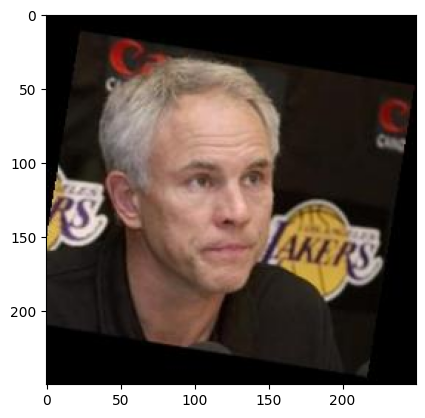

In [7]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

# Step 2
The basis for this project is that you can alter your implementation of AutoEncoders from the previous homework and add the necessary bits for a VAE.  Clearly state what is the difference between AutoEncoders and VAEs in terms of Applications, Architecture and Loss function.

Definition -

1) Autoencoders compress high-dimensional input data into a more comprehensible representation by using neural networks. From this reduced representation, the autoencoder then tries to reconstruct the input using fully connected or convolutional layers.

2) With variational autoencoders, your input is transferred onto a distribution, and instead of being translated into a fixed vector, a sample from that distribution is sent into your decoder network. The two terms for the reconstruction loss and the Kl divergence make up the function of a variational auto-loss encoder.

Applications -

1) AutoEncoders (AEs)
- Dimensionality Reduction: Compress high-dimensional input data into a more manageable representation.
- Image Reconstruction: Reconstruct images from compressed representations, which can be used for compression and denoising.
- Feature Learning: Learn efficient data representations for tasks like anomaly detection or segmentation, as used in self-driving cars.

2) Variational AutoEncoders (VAEs)
- Generative Modeling: Generate new data points similar to the training data, useful in image generation, text generation, etc.
Data Interpolation: Provide smooth and meaningful interpolations in the latent space.
- Anomaly Detection and Feature Learning: Similar to AEs, but with added benefits in understanding the probabilistic distribution of input data.

Architecture -

1) AutoEncoders (AEs)

- Encoder-Decoder Structure: Consists of an encoder that compresses data into a latent representation and a decoder that reconstructs data from this representation.
- Latent Space: Directly encodes data into a fixed vector in a latent space without probabilistic interpretation.
V
2) ariational AutoEncoders (VAEs)

- Probabilistic Framework: The encoder in a VAE maps inputs to a distribution in latent space, usually defined by mean and variance.
- Sampling and Reparameterization: VAEs use the reparameterization trick to sample from the latent distribution, adding stochasticity.

Loss Functions -

1) AutoEncoders (AEs)

- Objective Function: Typically involves reconstruction loss, such as the L2 norm (mean squared error) measuring the difference between the input and its reconstruction.

2) Variational AutoEncoders (VAEs)

- Reconstruction Loss: Similar to AEs, measures the fidelity of the reconstruction.
- Regularization Term: Includes a Kullback-Leibler (KL) divergence term to measure the difference between the learned distribution and a prior distribution (usually a unit Gaussian). This term ensures a structured and continuous latent space.

In summary, while both AEs and VAEs are used for learning efficient data representations, VAEs extend the concept by introducing a probabilistic approach to the encoding process and a regularization term in the loss function. This makes VAEs particularly powerful for generative tasks, allowing them to not only reconstruct but also generate new, diverse data samples that are similar to the training data.

# Step 3

Update your pytorch autoencoder model class to create your VAE. Assume the encoder produces the mean and log variance of the latent space.  

**Create separate functions for the encoder and decoder.**

In [141]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder Layers
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )

        # Latent space size
        latent_size = 22  # Example size of latent space

        # Adjusted fully connected layers for mean and log-variance
        self.fc_mu = nn.Linear(256 * 16 * 16, latent_size)
        self.fc_logvar = nn.Linear(256 * 16 * 16, latent_size)

        # Adjusted fully connected layer for decoder
        self.fc_dec = nn.Linear(latent_size, 256 * 16 * 16)

        # Decoder Layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid(),
        )

    def encode(self, x):
        h = self.encoder(x)
        h = h.view(h.size(0), -1)  # Flatten the output
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        z = self.fc_dec(z)
        z = z.view(z.size(0), 256, 16, 16)  # Reshape for the decoder
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


Key Differences in the VAE Architecture:

- 1) Introduction of a Probabilistic Latent Space: In the AE, the encoder directly maps input to a fixed latent space vector.
In the VAE, the encoder maps inputs to a distribution in latent space, characterized by mean (mu) and log variance (logvar). This allows the model to capture the underlying probability distribution of the data.

- 2) Reparameterization Trick: The VAE uses the reparameterization trick for the latent space. This involves sampling from the distribution defined by mu and logvar, which is crucial for backpropagation through stochastic nodes.

- 3) Increased Depth and Capacity: Your VAE architecture has additional convolutional layers in both the encoder and decoder, increasing the depth and capacity of the network. This can potentially allow the model to learn more complex representations.

- 4) Latent Space Dimensionality: The latent space size is explicitly defined (latent_size = 20), which is a design choice that can affect the model's ability to capture the essence of the data.

Explanation of the VAE Architecture:

- Encoder: Composed of several convolutional and ReLU layers, gradually reducing the spatial dimensions while increasing the depth (number of channels).
The final encoder output is flattened and fed into two different fully connected layers to produce mu and logvar.

- Sampling in Latent Space: The reparameterize function samples from the distribution defined by mu and logvar, creating a latent vector z. This process introduces variability and helps the model generate new data points.

- Decoder: Starts with a fully connected layer that expands the latent vector z back to a suitable size for convolutional layers.
Sequentially applies ConvTranspose layers and ReLU activations to upsample the feature maps back to the original input size.
The final ConvTranspose layer reduces the channels to 3 (assuming RGB images), and a sigmoid activation function is used to normalize the output pixel values to the range [0, 1].

Impact on Results:
- Generative Capability: The VAE architecture allows for the generation of new data samples by sampling different points in the latent space and decoding them, unlike the AE which is primarily used for reconstruction.
Regularization: The use of the KL divergence in the loss function (implicit in the architecture) regularizes the latent space, encouraging the encoder to learn a distribution that approximates a standard Gaussian. This leads to better generalization and smoother interpolations in the latent space.

## Step 4
Create an instance of the new class, pass an image to the model

*  print the shape of the output of the **encoder**. Explain how would you generate new samples in the latent space. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.
*  use the decoder to create new images. Print the shape of the output and verify that the forward pass is working correctly.

In [142]:
# Instantiate the model
model = VAE().to(device)

# Initialize your DataLoader to get a batch of images
dataiter = iter(dataloader)
images, _ = dataiter.__next__()

# Check if CUDA is available and move the model and input to GPU if it is
if torch.cuda.is_available():
    model = model.cuda()
    images = images.cuda()

# Take the first image from the batch
# input_image = images[0].unsqueeze(0)

# Pass the image through the VAE model
output, mu, logvar = model(images)

# Print the shapes of the outputs
print("Shape of encoded output (mu and logvar):", mu.shape, logvar.shape )
print("Shape of decoded output:", output.shape)

Shape of encoded output (mu and logvar): torch.Size([32, 22]) torch.Size([32, 22])
Shape of decoded output: torch.Size([32, 3, 250, 250])


Understanding the Latent Space in VAEs:

- Latent Variables (mu and logvar): In VAEs, the encoder network doesn't produce a single point in the latent space for a given input (as in standard AutoEncoders). Instead, it generates parameters (mean mu and log variance logvar) of a probability distribution representing the input data in the latent space. This distribution is typically assumed to be Gaussian (normal), where mu is the mean and exp(logvar) gives the variance.

Generating New Samples:

- Sampling from the Distribution: The core idea is to randomly sample points from this Gaussian distribution defined by mu and logvar. These sampled points are considered new representations in the latent space.
However, direct sampling is not straightforward for backpropagation during training, as it involves a random step that doesn't have a gradient.

- Reparameterization Trick: To overcome this, VAEs use the "reparameterization trick". Instead of sampling from the distribution directly, you sample from a standard normal distribution and then reparameterize it to obtain samples from the desired distribution.
The reparameterized sample is computed as sample = mu + epsilon * sqrt(exp(logvar)), where epsilon is a random sample from a standard normal distribution. This step ensures that the sampling process is differentiable and allows gradients to flow back through the network during training.

- Decoding the Sample: Once you have the sampled points (new latent representations), you pass them through the decoder part of the VAE.
The decoder then reconstructs these points back into the data space, generating new data instances that are similar to what the model was trained on.

Conceptual Understanding:

- The process of generating new samples in a VAE is fundamentally different from that in a standard AE. While AEs simply compress and decompress data, VAEs understand and model the probability distribution of the data in the latent space.
- By sampling from the latent space and decoding these samples, VAEs can generate new instances that are variations of the training data. This is a powerful generative capability, allowing VAEs to produce new content that's never been seen before, but is statistically similar to the original dataset.
This generative process is particularly useful in fields like image generation, where you want to create new images that share characteristics with a given set of images (e.g., faces, animals, etc.).

Primary Purpose:
- The primary purpose of this code is to demonstrate how to process a batch of images using a VAE, focusing on a single image for simplicity.
- It showcases the use of a VAE for encoding an image into a latent space (represented by mu and logvar) and then decoding it back to reconstruct the original image (represented by output).
- This can be part of a larger process, such as training the VAE, visualizing how well the VAE reconstructs images, or using the latent space representation for other tasks like image generation or anomaly detection.
- It also serves as an example of handling model and data with CUDA for GPU acceleration, which is a common practice in deep learning to speed up computations.

##  Step 5
* Print the total number of parameters in the model
* Explain what loss should be used here. Describe in your own words the terms of the loss function and what goal each term of the loss function achieves. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.


In [143]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f"Total number of parameters in the model: {total_params}")

Total number of parameters in the model: 5397583


* create an optimizer for training

In [144]:
import torch.optim as optim

optim = torch.optim.Adam(model.parameters(), lr=0.001)

In [145]:
def loss_function(recon_x, x, mean, log_var):


    # Reconstruction loss (BCE)
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # KL divergence
    kl_div = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    return BCE + kl_div


Loss Function:

Reconstruction Loss
 - Purpose: The reconstruction loss measures how well the VAE can reconstruct the input data after encoding and decoding it. In other words, it assesses the fidelity of the reconstructed image (or data) compared to the original input.

- Implementation: I've used Binary Cross-Entropy (BCE) as the reconstruction loss. This choice is particularly effective when dealing with data like images where pixels are normalized between 0 and 1. The BCE loss calculates the difference between each pixel in the original image (x) and the reconstructed image (recon_x), providing a measure of how much information is lost in the reconstruction process.

- Goal: Minimizing this loss helps the model learn to preserve as much information as possible from the original input through the encoding-decoding process, leading to more accurate and detailed reconstructions.

KL Divergence
- Purpose: The Kullback-Leibler (KL) divergence adds a regularization component to the VAE's loss function. It measures how much the learned distribution (represented by mean and log_var) in the latent space deviates from a prior distribution, typically a standard normal distribution.

- Implementation: Your code implements the KL divergence calculation using the mean (mean) and log variance (log_var) of the latent space. The term -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp()) computes the divergence between the learned distribution and a standard normal distribution.

- Goal: This term ensures that the latent space doesn't just memorize the training data but learns a well-structured and continuous representation. It encourages the model to distribute the data points in the latent space in a way that is similar to a normal distribution. This aspect is crucial for generating new data points that are diverse yet plausible when compared to the training dataset.

Overall Objective
- The total loss is a sum of these two components. By balancing reconstruction fidelity (how well the model can rebuild the input data) and latent space regularization (structuring the latent space in a meaningful way), the VAE can efficiently learn to both represent and generate data.

- In practical terms, this means your model will not only be good at compressing and reconstructing the input data, but also capable of generating new, unseen data points that resemble the original dataset, making VAEs exceptionally powerful for generative tasks.

##  Step 6
Write a training loop and start training the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [146]:
# Number of epochs
num_epochs = 10

for epoch in range(num_epochs):
    total_loss = 0
    for batch_idx, (data, _) in enumerate(dataloader):
        data = data.to(device)
        # Reset gradients
        optim.zero_grad()

        # Forward pass
        recon_batch, mu, logvar = model(data)

        # Compute loss
        loss = loss_function(recon_batch, data, mu, logvar)

        # Backward pass and optimize
        loss.backward()
        optim.step()

        total_loss += loss.item()

    # Average loss for this epoch
    epoch_loss = total_loss / len(dataloader.dataset)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss}")

Epoch [1/10], Loss: 102621.20639117625
Epoch [2/10], Loss: 97707.71997053713
Epoch [3/10], Loss: 97174.08903074714
Epoch [4/10], Loss: 96905.17830701821
Epoch [5/10], Loss: 96673.6181536602
Epoch [6/10], Loss: 96516.87648258668
Epoch [7/10], Loss: 96266.01888645464
Epoch [8/10], Loss: 95975.65608710433
Epoch [9/10], Loss: 95765.37504721613
Epoch [10/10], Loss: 95640.52135113697


1. Poor Reconstruction Quality
Problem: The VAE is not able to reconstruct the input data accurately.
  - Solutions:
Check Network Capacity: Ensure the model has enough capacity (layers, neurons) to learn the complex features of the data.
Adjust Loss Function Weights: The balance between reconstruction loss and KL divergence might need tweaking.
Data Preprocessing: Verify that the data is correctly preprocessed (normalized, etc.) before feeding it into the model.

2. High Reconstruction Loss
Problem: The reconstruction loss remains high, and the model doesn't seem to be learning effectively.
  - Solutions:
Learning Rate Adjustment: Experiment with different learning rates.
Training Duration: Train for more epochs, as sometimes the model needs more time to converge.
Batch Size: Modify the batch size, as smaller or larger batches can impact the learning dynamics.

In the event that the loss does not decline as anticipated, we can look into the following:

- Raise or Lower Model Complexity: Determine whether the VAE architecture is suitable for the task, taking into account the size of the latent space.
- Try adjusting the encoder and decoder's hidden units and layer counts.
- Fine-tune the learning rate in light of how it affects convergence.
- Experiment with various learning rate optimizers and schedulers.
- Examine Loss Function: Since the loss function comprises of both a KL divergence term and a reconstruction loss, make sure it is implemented appropriately. Make sure there are appropriate weights between these phrases.
- Keep an eye on gradients. During training, make sure the gradients are not too big or too little to prevent the explosion or disappearance of the gradient.

Purpose of the Training Loop
- The primary goal of this training loop is to train the VAE model on your dataset. Training involves learning to reconstruct the input data while ensuring that the latent space has good properties (like being normally distributed), as enforced by the loss function.
- By iterating over multiple epochs, the model has the opportunity to see the data multiple times, allowing it to refine its parameters and improve its reconstruction and generation capabilities.
- This loop also includes essential steps like loss calculation and backpropagation, which are fundamental for neural network training.
Monitoring the epoch loss helps in understanding the training progress and in debugging. If the loss decreases over time, it indicates that the model is learning effectively.

##  Step 7

Take a random image from the dataset and plot it together with new samples generated.

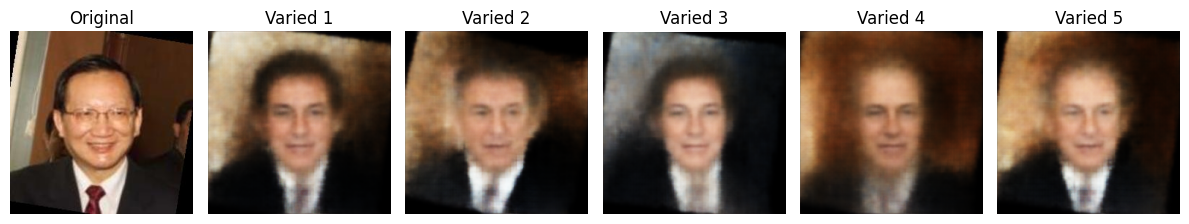

In [154]:
# Set the VAE model to evaluation mode
model.eval()

# Randomly select an image from the dataset
with torch.no_grad():
    batch_images, _ = next(iter(dataloader))
    idx = torch.randint(0, batch_images.size(0), (1,)).item()
    selected_image = batch_images[idx].unsqueeze(0).to(device)

    # Encoding the image to get the latent space parameters
    latent_mu, latent_logvar = model.encode(selected_image)

    # Sample from the latent space using reparameterization
    latent_std = torch.exp(0.5 * latent_logvar)
    random_noise = torch.randn_like(latent_std)
    latent_sample = latent_mu + random_noise * latent_std

    # Display the original image
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 6, 1)
    original_img = selected_image.cpu().squeeze(0).permute(1, 2, 0)
    plt.imshow(original_img)
    plt.title("Original")
    plt.axis('off')

    # Create and display 5 variations
    for variation in range(5):
        # Amplify variations in the latent space
        amplified_variation = latent_sample + 0.5 * torch.randn_like(latent_sample)

        # Decode the altered latent vector
        varied_img = model.decode(amplified_variation)

        # Plotting the generated image
        plt.subplot(1, 6, variation + 2)
        img_to_plot = varied_img.cpu().squeeze(0).permute(1, 2, 0)
        plt.imshow(img_to_plot)
        plt.title(f"Varied {variation + 1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


Purpose and Usage
- `Model Evaluation and Visualization`: After training your VAE, you can use this code to visually assess how well your model has learned to generate new data. This is a critical step in understanding the performance of generative models.
- `Comparing Original and Generated Images`: By displaying an original image from the dataset and then showing generated images, you can visually compare the quality and diversity of the generated images with respect to the real data.
Generative Capability Inspection: This code is particularly useful for inspecting the generative capabilities of your VAE. The random latent vectors act as seeds for image generation, showcasing the variety of outputs your model can produce.